## Feature Engineering

### Additional Thoughts:
 - Do we need to scale anything from the data processing?

### Approach -> Focus on additional 1. physiological metrics 2. demographic metrics 
- already have calorie burn rate, fitness metric (unsure of the validity of the fitness metric)
- BMI 
- BMR -> mifflin st jeor equations (male v female)
- heart rate %
- effort score (duration and heart rate percentage)
- thermoregulatory strain (body temp and duration) (even with temp being unrealistic, we kept the data in there so lets use it?)
- TDEE?
- NEAT (as a way to determine baseline activity level outside of the exercise? relies on a lot of calculated measurements so may be unreliable/too highly correlated)



- age based (needs elaboration, don't think there is enough info to work on something like garmin's fitness age v actual age)



In [1]:
# initial data loading, formula creation, gen prep, etc
# combine into singular df after cleaning, add a tag for og vs synthetic so can separate again later

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns 

sys.path.append('../src')
from data_processing import *


synthetic_train_df = load_data('../data/raw/synthetic_train.csv', dataset_type='synthetic_train')
og_all_data_df = load_data('../data/raw/og_calories.csv', dataset_type='og_all')

# need to clean/rename columns for when we combine
clean_column_names(synthetic_train_df)
clean_column_names(og_all_data_df)
og_all_data_df = og_all_data_df.rename(columns={'gender': 'sex'})


# for each df, add a tag for their type/name for splitting later 
synthetic_train_df['tag'] = 'syn_train'
og_all_data_df['tag'] = 'og_all'

combined_df = pd.concat([synthetic_train_df, og_all_data_df], ignore_index=True)
combined_df.shape


Loaded synthetic_train dataset: (750000, 9)
Loaded og_all dataset: (15000, 9)


(765000, 11)

In [2]:
combined_df.head()

,id,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,user_id
0,0.0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,NaN
1,1.0,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,NaN
2,2.0,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,NaN
3,3.0,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,NaN
4,4.0,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,NaN


In [3]:
combined_df.drop(columns=['id', 'user_id'], inplace=True)


In [4]:
#combined_df = kg_to_lbs(combined_df)
#combined_df = celsius_to_farhenheit(combined_df)
#combined_df = cm_to_in(combined_df)

#combined_df.head()

In [5]:
numerical_cols = identify_numerical_columns(combined_df)
print(numerical_cols)

['age', 'height', 'weight', 'duration', 'heart_rate', 'body_temp', 'calories']


## Think we can start with the feature engineering now

In [6]:
combined_df = calculate_calorie_burn_rate(combined_df)
combined_df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000


In [7]:
'''
    BMI formula: weight (kg) / height^2 (m)

    Ranges:
        - 18.5 -> underweight
        - 18.5 - 25 -> healthy
        - 25 - 30 -> overweight
        - 31 - 35 -> obesity 1
        - 35 - 40 -> obesity 2
        - 40+ -> obesity 3
'''

import numpy as np

#combined_df['bmi'] = (combined_df['weight'] / 2.2046) / (((combined_df['height'] * 2.54) / 100) ** 2)
combined_df['bmi'] = combined_df['weight'] / ((combined_df['height'] / 100) ** 2)

def categorize_bmi(df):
    conditions = [
        df['bmi'] < 18.5,
        (df['bmi'] >= 18.5) & (df['bmi'] < 25),
        (df['bmi'] >= 25) & (df['bmi'] < 30),
        (df['bmi'] >= 30) & (df['bmi'] < 35),
        (df['bmi'] >= 35) & (df['bmi'] < 40),
        df['bmi'] >= 40
    ]

    choices = [
        'underweight',
        'healthy',
        'overweight',
        'obesity1',
        'obesity2',
        'obesity3'
    ]
    
    df['bmi_category'] = np.select(conditions, choices, default='unknown')
    return df

combined_df = categorize_bmi(combined_df)
combined_df['bmi_category'].value_counts()


bmi_category
healthy        498850
overweight     265943
obesity1          107
underweight        76
obesity2           19
obesity3            5
Name: count, dtype: int64

In [8]:
combined_df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy


In [9]:
'''
    BMR calculations using mifflin - st jeor formulas
        Men:
            10 * weight(kg) + 6.25 x height(cm) - 5 x age + 5
        Women:
            10 * weight(kg) + 6.25 x height(cm) - 5 x age - 161
'''

def calculate_bmr(df):
    conditions = [
        df['sex'] == 'male',
        df['sex'] == 'female'
    ]

    choices = [
        10 * df['weight'] + 6.25 * df['height'] - 5 * df['age'] + 5,
        10 * df['weight'] + 6.25 * df['height'] - 5 * df['age'] - 161
    ]
    
    df['bmr'] = pd.to_numeric(np.select(conditions, choices, default='unknown'), errors='coerce')
    return df

combined_df = calculate_bmr(combined_df)
combined_df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category,bmr
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy,1826.25
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy,1137.75
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy,1230.25
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy,2005.00
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy,1296.50


In [10]:
# calories per bmr for metabolic efficiency

def calculate_metabolic_efficiency(df):
    df['met_efficiency'] = df['calories'] / df['bmr']

    return df

combined_df = calculate_metabolic_efficiency(combined_df)
combined_df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category,bmr,met_efficiency
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy,1826.25,0.082136
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy,1137.75,0.029884
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy,1230.25,0.023572
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy,2005.00,0.069825
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy,1296.50,0.112611


In [11]:
# body surface area using dubois formula

def calculate_bsa(df):
    df['bsa'] = 0.007184 * (df['height'] ** 0.725) * (df['weight'] ** 0.425)

    return df

combined_df = calculate_bsa(combined_df)
combined_df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category,bmr,met_efficiency,bsa
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy,1826.25,0.082136,2.090124
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy,1137.75,0.029884,1.644056
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy,1230.25,0.023572,1.674718
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy,2005.00,0.069825,2.199443
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy,1296.50,0.112611,1.677683


In [12]:
# heart rate percentage calculation

def calculate_hr_percentage(df):

    theoretical_max = 220 - df['age']

    df['hr_percentage'] = df['heart_rate'] / theoretical_max

    return df

combined_df = calculate_hr_percentage(combined_df)
combined_df.head()


,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category,bmr,met_efficiency,bsa,hr_percentage
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy,1826.25,0.082136,2.090124,0.548913
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy,1137.75,0.029884,1.644056,0.544872
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy,1230.25,0.023572,1.674718,0.497041
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy,2005.00,0.069825,2.199443,0.525000
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy,1296.50,0.112611,1.677683,0.560440


In [13]:
# hr zone 

def categorize_hr_zone(df):
    conditions = [
        df['hr_percentage'] < 0.50,
        (df['hr_percentage'] >= .50) & (df['hr_percentage'] < .60),
        (df['hr_percentage'] >= .60) & (df['hr_percentage'] < .70),
        (df['hr_percentage'] >= .70) & (df['hr_percentage'] < .80),
        (df['hr_percentage'] >= .80) & (df['hr_percentage'] < .90),
        df['hr_percentage'] >= .90
    ]

    choices = [
        'Light',
        'Zone 1',
        'Zone 2',
        'Zone 3',
        'Zone 4',
        'Zone 5'
    ]

    df['hr_zone'] = np.select(conditions, choices, default='unknown')

    return df


combined_df = categorize_hr_zone(combined_df)
combined_df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category,bmr,met_efficiency,bsa,hr_percentage,hr_zone
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy,1826.25,0.082136,2.090124,0.548913,Zone 1
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy,1137.75,0.029884,1.644056,0.544872,Zone 1
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy,1230.25,0.023572,1.674718,0.497041,Light
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy,2005.00,0.069825,2.199443,0.525000,Zone 1
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy,1296.50,0.112611,1.677683,0.560440,Zone 1


In [14]:
# effort score

def calculate_effort_score(df):
    
    df['effort_score'] = df['hr_percentage'] * df['duration']
    return df

combined_df = calculate_effort_score(combined_df)
combined_df.head()



,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category,bmr,met_efficiency,bsa,hr_percentage,hr_zone,effort_score
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy,1826.25,0.082136,2.090124,0.548913,Zone 1,14.271739
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy,1137.75,0.029884,1.644056,0.544872,Zone 1,4.358974
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy,1230.25,0.023572,1.674718,0.497041,Light,3.479290
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy,2005.00,0.069825,2.199443,0.525000,Zone 1,13.125000
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy,1296.50,0.112611,1.677683,0.560440,Zone 1,14.010989


In [15]:
# thermoregulatory strain

def calculate_thermoregulatory_strain(df):

    df['thermo_strain'] = df['body_temp'] * df['duration']
    return df

combined_df = calculate_thermoregulatory_strain(combined_df)
combined_df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category,bmr,met_efficiency,bsa,hr_percentage,hr_zone,effort_score,thermo_strain
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy,1826.25,0.082136,2.090124,0.548913,Zone 1,14.271739,1066.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy,1137.75,0.029884,1.644056,0.544872,Zone 1,4.358974,317.6
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy,1230.25,0.023572,1.674718,0.497041,Light,3.479290,278.6
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy,2005.00,0.069825,2.199443,0.525000,Zone 1,13.125000,1017.5
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy,1296.50,0.112611,1.677683,0.560440,Zone 1,14.010989,1015.0


In [16]:
# age bin

def categorize_age(df):
    conditions = [
        df['age'] < 20,
        (df['age'] >= 20) & (df['age'] <= 30),
        (df['age'] > 30) & (df['age'] <= 40),
        (df['age'] > 40) & (df['age'] <= 50),
        (df['age'] > 50) & (df['age'] <= 60),
        (df['age'] > 60) & (df['age'] <= 70),
        df['age'] > 70
    ]

    choices = [
        'Under 20',
        '20s',
        '30s',
        '40s',
        '50s',
        '60s',
        '70s+'
    ]

    df['age_bin'] = np.select(conditions, choices, default='unknow')

    return df

combined_df = categorize_age(combined_df)
combined_df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories,tag,calorie_burn_rate,bmi,bmi_category,bmr,met_efficiency,bsa,hr_percentage,hr_zone,effort_score,thermo_strain,age_bin
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,syn_train,5.769231,22.955684,healthy,1826.25,0.082136,2.090124,0.548913,Zone 1,14.271739,1066.0,30s
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,syn_train,4.250000,22.582709,healthy,1137.75,0.029884,1.644056,0.544872,Zone 1,4.358974,317.6,60s
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,syn_train,4.142857,24.690405,healthy,1230.25,0.023572,1.674718,0.497041,Light,3.479290,278.6,50s
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,syn_train,5.600000,24.414062,healthy,2005.00,0.069825,2.199443,0.525000,Zone 1,13.125000,1017.5,20s
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,syn_train,5.840000,22.136740,healthy,1296.50,0.112611,1.677683,0.560440,Zone 1,14.010989,1015.0,30s


### Post-Feature Engineering Thoughts:

#### There are certainly a few pairs of variables that I think are at high risk of collinearity (which will be tested a bit below, but handled mostly during the actual model creation and testing phase)
- BSA calculated from height and weight
- BMI calculated from height and weight
- BMR calculated from height, weight, and age
- Thermo strain calculated from duration and body temp
- Effort score calculated from hr_percentage and duration

#### In order to potentially combat these collinear features, we can implement a few strategies:
- Correlation matrix analysis (shown below)
- PCA on correlated groups
- L1 Regularization
- VIF (Variance Inflation Factor)
- Different feature groups for testing 

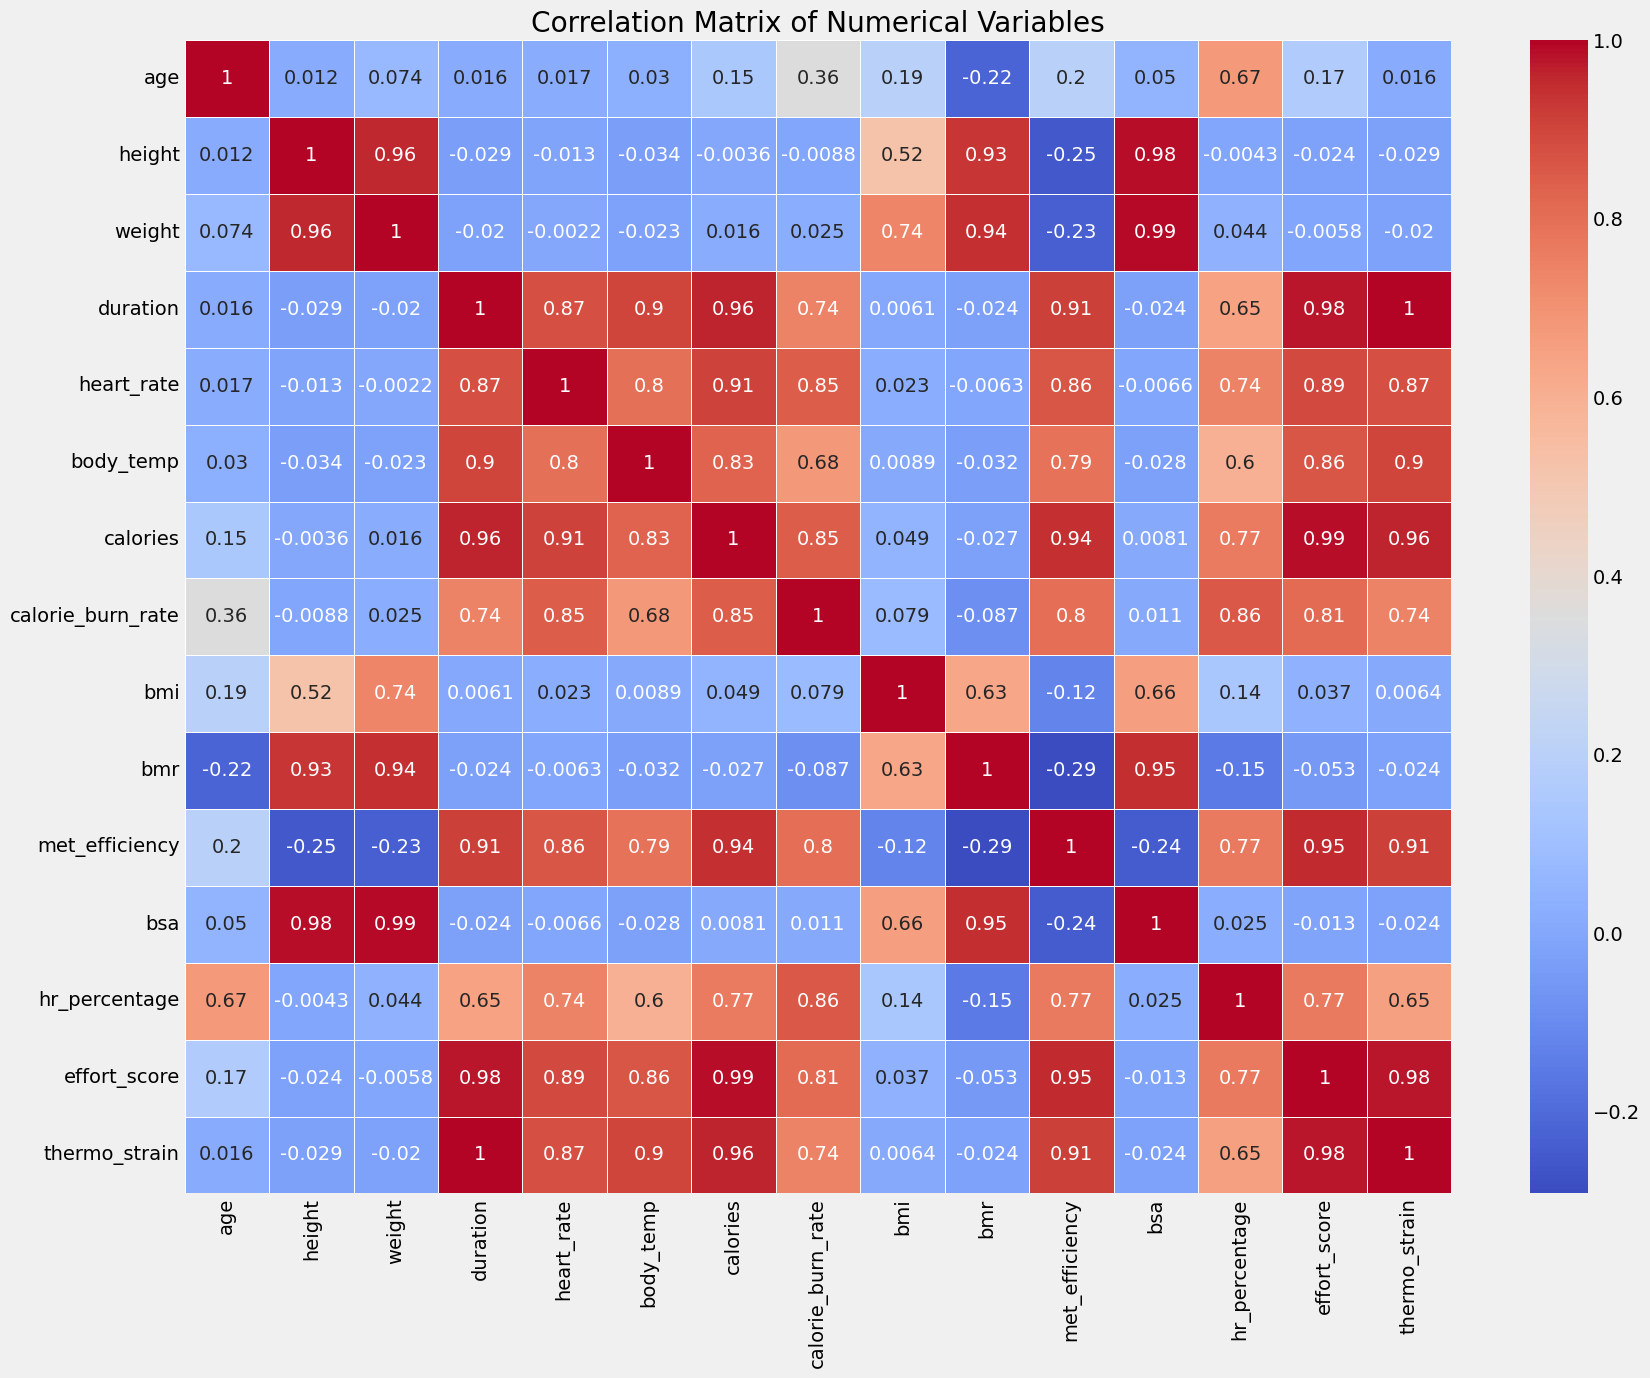

In [17]:
corr_matrix = combined_df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(18,14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

In [18]:
def display_high_correlations(df, threshold=0.8, exclude_target=None):
    """
    Display high correlations in a clean, readable format
    
    Args:
        df: DataFrame with numerical columns
        threshold: Correlation threshold (default 0.8)
        exclude_target: Target variable to exclude from analysis
    """
    
    # find high correlations
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            
            # skip if involves target variable (if specified)
            if exclude_target and (var1 == exclude_target or var2 == exclude_target):
                continue
                
            if abs(corr_val) >= threshold:
                high_corr_pairs.append({
                    'Variable 1': var1,
                    'Variable 2': var2,
                    'Correlation': corr_val,
                    'Abs_Correlation': abs(corr_val)
                })
    
    # convert to DataFrame and sort
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Abs_Correlation', ascending=False)
    
    print(f"HIGH CORRELATIONS (|r| >= {threshold})")
    print("=" * 60)
    print(f"Found {len(high_corr_df)} high correlation pairs:\n")
    
    for idx, row in high_corr_df.iterrows():
        print(f"{row['Variable 1']} ↔ {row['Variable 2']}: {row['Correlation']:.3f}")
    
    return high_corr_df

high_corr_df = display_high_correlations(combined_df, 0.8, None)
high_corr_df.head(40)





HIGH CORRELATIONS (|r| >= 0.8)
Found 30 high correlation pairs:

duration ↔ thermo_strain: 1.000
weight ↔ bsa: 0.993
calories ↔ effort_score: 0.988
height ↔ bsa: 0.985
effort_score ↔ thermo_strain: 0.979
duration ↔ effort_score: 0.978
calories ↔ thermo_strain: 0.961
duration ↔ calories: 0.960
height ↔ weight: 0.958
met_efficiency ↔ effort_score: 0.950
bmr ↔ bsa: 0.949
calories ↔ met_efficiency: 0.944
weight ↔ bmr: 0.944
height ↔ bmr: 0.934
met_efficiency ↔ thermo_strain: 0.913
duration ↔ met_efficiency: 0.913
heart_rate ↔ calories: 0.909
duration ↔ body_temp: 0.903
body_temp ↔ thermo_strain: 0.903
heart_rate ↔ effort_score: 0.893
heart_rate ↔ thermo_strain: 0.875
duration ↔ heart_rate: 0.875
body_temp ↔ effort_score: 0.864
heart_rate ↔ met_efficiency: 0.860
calorie_burn_rate ↔ hr_percentage: 0.858
calories ↔ calorie_burn_rate: 0.847
heart_rate ↔ calorie_burn_rate: 0.846
body_temp ↔ calories: 0.829
calorie_burn_rate ↔ effort_score: 0.811
calorie_burn_rate ↔ met_efficiency: 0.800


,Variable 1,Variable 2,Correlation,Abs_Correlation
10,duration,thermo_strain,0.999934,0.999934
4,weight,bsa,0.993124,0.993124
21,calories,effort_score,0.988477,0.988477
2,height,bsa,0.984880,0.984880
29,effort_score,thermo_strain,0.978590,0.978590
9,duration,effort_score,0.978077,0.978077
22,calories,thermo_strain,0.960818,0.960818
7,duration,calories,0.959819,0.959819
0,height,weight,0.957966,0.957966
27,met_efficiency,effort_score,0.950498,0.950498


In [19]:
def categorize_correlations(high_corr_df):
    """
    categorize correlations by type for better understanding
    """
    categories = {
        'Calculated from Base Features': [],
        'Interaction Terms': [],
        'Physiological Related': [],
        'Duration Related': [],
        'Other': []
    }
    
    for idx, row in high_corr_df.iterrows():
        var1, var2 = row['Variable 1'], row['Variable 2']
        pair = f"{var1} ↔ {var2}"
        corr = row['Correlation']
        
        # calculated features
        if any(calc in [var1, var2] for calc in ['bmi', 'bmr', 'bsa', 'hr_percentage']):
            categories['Calculated from Base Features'].append(f"{pair}: {corr:.3f}")
        
        # interaction terms
        elif any(inter in [var1, var2] for inter in ['effort_score', 'thermo_strain', 'met_efficiency']):
            categories['Interaction Terms'].append(f"{pair}: {corr:.3f}")
        
        # duration related
        elif 'duration' in [var1, var2]:
            categories['Duration Related'].append(f"{pair}: {corr:.3f}")
        
        # physiological
        elif any(phys in [var1, var2] for phys in ['height', 'weight', 'age', 'heart_rate', 'body_temp']):
            categories['Physiological Related'].append(f"{pair}: {corr:.3f}")
        
        else:
            categories['Other'].append(f"{pair}: {corr:.3f}")
    
    print("\nCORRELATION CATEGORIES:")
    print("=" * 60)
    
    for category, pairs in categories.items():
        if pairs:
            print(f"\n{category}:")
            print("-" * len(category))
            for pair in pairs:
                print(f"  • {pair}")

categorize_correlations(high_corr_df)


CORRELATION CATEGORIES:

Calculated from Base Features:
-----------------------------
  • weight ↔ bsa: 0.993
  • height ↔ bsa: 0.985
  • bmr ↔ bsa: 0.949
  • weight ↔ bmr: 0.944
  • height ↔ bmr: 0.934
  • calorie_burn_rate ↔ hr_percentage: 0.858

Interaction Terms:
-----------------
  • duration ↔ thermo_strain: 1.000
  • calories ↔ effort_score: 0.988
  • effort_score ↔ thermo_strain: 0.979
  • duration ↔ effort_score: 0.978
  • calories ↔ thermo_strain: 0.961
  • met_efficiency ↔ effort_score: 0.950
  • calories ↔ met_efficiency: 0.944
  • met_efficiency ↔ thermo_strain: 0.913
  • duration ↔ met_efficiency: 0.913
  • body_temp ↔ thermo_strain: 0.903
  • heart_rate ↔ effort_score: 0.893
  • heart_rate ↔ thermo_strain: 0.875
  • body_temp ↔ effort_score: 0.864
  • heart_rate ↔ met_efficiency: 0.860
  • calorie_burn_rate ↔ effort_score: 0.811
  • calorie_burn_rate ↔ met_efficiency: 0.800

Physiological Related:
---------------------
  • height ↔ weight: 0.958
  • heart_rate ↔ calorie